# Лабораторная работа №1

## Задания

1. С помощью приложенного файла сгенерировать временной ряд.
2. Отрисовать ряд.
3. Провести классические статистические тесты.
4. Провести разделение ряда на компоненты.
5. Отрисовать автокорреляционные функции.
6. Выбрать статистический метод моделирования. Привести текстовое обоснование выбора. Смоделировать ряд, сделав предсказание на разумный период.
7. Провести анализ метрик.
8. Изобразить график модели с предсказанием с учетом возможных ошибок.

## Реализация

### Задание 1. Генерация

In [1]:
import numpy as np
from datetime import datetime, timedelta


def generate_time_series(n_points=1000, has_trend=True, has_seasonality=True, seed=None):
    """
    Генерирует временной ряд со случайными параметрами без использования
    Pandas
    Параметры:
    ----------
    n_points : int
    Количество точек данных
    has_trend : bool
    Добавлять ли тренд
    has_seasonality : bool
    Добавлять ли сезонность
    seed : int или None
    Seed для воспроизводимости
    Возвращает:
    -----------
    tuple: (dates, values) где dates - список строк дат, values - список
    значений
    """
    
    if seed is not None:
        np.random.seed(seed)
        
    # Генерируем временные метки (ежедневные данные начиная с 2020-01-01)
    start_date = datetime(2020, 1, 1)
    dates = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(n_points)]
    
    # Базовый шум (случайная компонента)
    noise = np.random.normal(0, 5, n_points)
    
    # Инициализируем компоненты
    trend_component = np.zeros(n_points)
    seasonal_component = np.zeros(n_points)
    
    # Генерируем тренд, если требуется
    if has_trend:
        # Случайно выбираем тип тренда: линейный, квадратичный или логарифмический
        trend_type = np.random.choice(['linear', 'quadratic', 'logarithmic'])

        if trend_type == 'linear':
            # Линейный тренд: y = mx + b
            slope = np.random.uniform(-0.5, 0.5) # случайный наклон
            intercept = np.random.uniform(50, 100) # случайное начальное значение
            trend_component = slope * np.arange(n_points) + intercept
            
        elif trend_type == 'quadratic':
            # Квадратичный тренд: y = ax^2 + bx + c
            a = np.random.uniform(-0.001, 0.001)
            b = np.random.uniform(-0.1, 0.1)
            c = np.random.uniform(50, 100)
            x = np.arange(n_points)
            trend_component = a * x**2 + b * x + c
            
        else: # logarithmic
            # Логарифмический тренд: y = a*log(x+1) + b
            a = np.random.uniform(10, 30)
            b = np.random.uniform(50, 100)
            trend_component = a * np.log(np.arange(n_points) + 1) + b
        
    # Генерируем сезонность, если требуется
    if has_seasonality:
        # Случайное количество сезонных компонент (1-3)
        n_seasons = np.random.randint(1, 4)
        
        for _ in range(n_seasons):
            # Случайные параметры для каждой сезонной компоненты
            amplitude = np.random.uniform(10, 30) # амплитуда
            period = np.random.uniform(30, 365) # период в днях
            phase = np.random.uniform(0, 2*np.pi) # фаза
            
            # Создаем сезонную компоненту (синусоида)
            seasonal_component += amplitude * np.sin(2*np.pi*np.arange(n_points)/period + phase)
        
    # Комбинируем все компоненты
    values = noise + trend_component + seasonal_component
    
    return dates, values

In [2]:
days = 1000  # изначальный ряд
days_forecast = 100  # сколько дней предсказываем

dates_total, values_total = generate_time_series(n_points=days+days_forecast, seed=2)  # генерируем сразу все дни для сравнения метрик

dates, values = dates_total[:-days_forecast], values_total[:-days_forecast]
dates_forecast, values_true = dates_total[-days_forecast:], values_total[-days_forecast:]

### Задание 2. Отрисовка

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_time_series(dates, values, figsize=(14, 6)):
    """
    Визуализирует временной ряд без использования Pandas
    Параметры:
    ----------
    dates : list
    Список дат в строковом формате
    values : list или np.array
    Список значений временного ряда
    figsize : tuple
    Размер фигуры
    """
    
    # Преобразуем строки дат в объекты datetime для matplotlib
    date_objects = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in dates]
    
    plt.figure(figsize=figsize)
    
    # Строим график временного ряда
    plt.plot(date_objects, values, label='Временной ряд', color='blue', linewidth=1.5)
    plt.title('Сгенерированный временной ряд', fontsize=16, fontweight='bold')
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Значение', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Автоматически форматируем ось X для дат
    plt.gcf().autofmt_xdate()
    
    # Добавляем информацию о данных
    values_array = np.array(values)
    stats_text = f"Всего точек: {len(values)}\nСреднее: {np.mean(values_array):.2f}\nСтандартное отклонение: {np.std(values_array):.2f}"
    plt.figtext(0.02, 0.02, stats_text, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
    
    plt.tight_layout()
    
    plt.show()

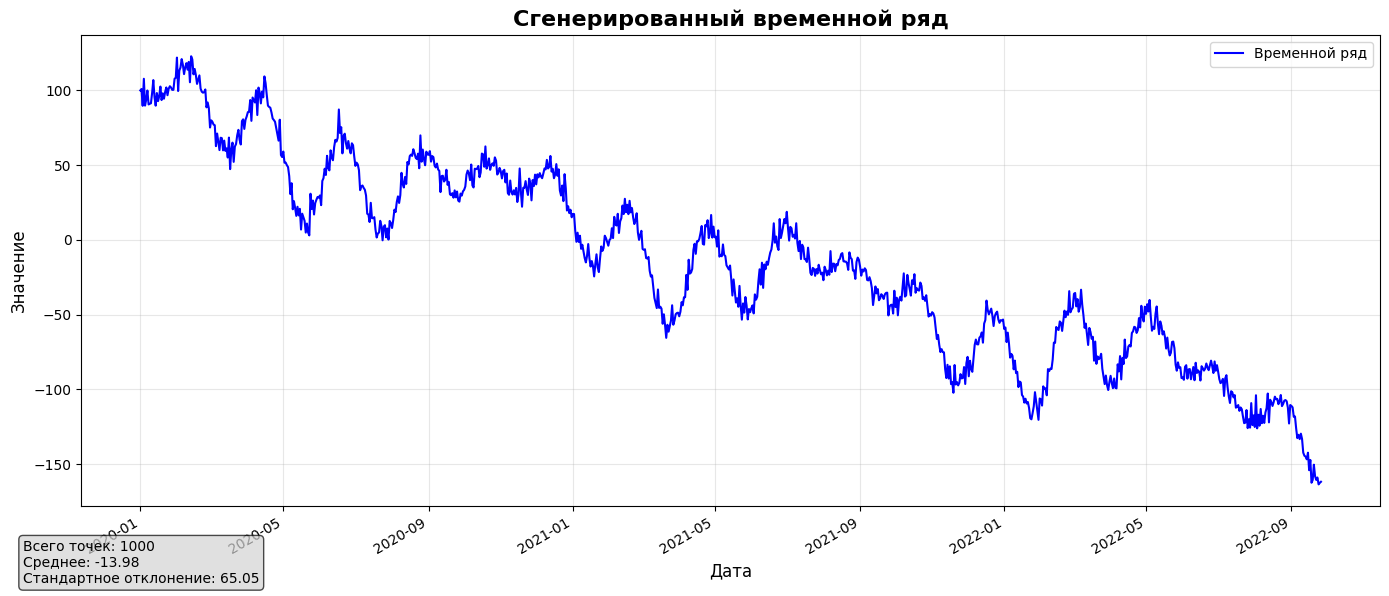

In [4]:
plot_time_series(dates, values)

### Задание 3. Классические статистические тесты

Под классическими тестами я понял следующие тесты:

1. Расширенный тест Дикки-Фуллера (ADF)
2. Тест Квятковского-Филлипса-Шмидта-Шина (KPSS)
3. Тест Филлипса-Перрона (PP)

#### Библиотеки

В библиотеке statsmodels уже есть ADF и KPSS, но нет PP. Зато она есть в библиотеке arch

In [5]:
from statsmodels.tsa.api import adfuller, kpss
from arch.unitroot import PhillipsPerron

#### ADF

In [6]:
adf_result = adfuller(values)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f" {key}: {value}")

ADF Statistic: -0.9481787676321858
p-value: 0.7716929116839998
Critical Values:
 1%: -3.43706091543889
 5%: -2.8645028204932483
 10%: -2.568347558984588


Видно, что статистика ADF сильно отличается от критических значений и p значение сильно больше 0.05. Следовательно, нет оснований отвергать нулевую гипотезу о том, что ряд нестационарен

#### KPSS

In [7]:
kpss_result = kpss(values)

print("KPSS Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])
print("Critical Values:")
for key, value in kpss_result[3].items():
    print(f" {key}: {value}")

KPSS Statistic: 4.597336494720676
p-value: 0.01
Critical Values:
 10%: 0.347
 5%: 0.463
 2.5%: 0.574
 1%: 0.739


/tmp/ipykernel_11238/3629456828.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(values)


Здесь же p значение меньше 0.05. Следовательно, отвергаем нулевую гипотезу о том, что ряд стационарен

#### PP

In [8]:
pp_result = PhillipsPerron(values)

print(pp_result.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.350
P-value                         0.606
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Последний тест также показывает то, что ряд нестационарен

В совокупности этих 3 тестов можно заключить, что ряд нестационарен

### Задание 4. Разделение на компоненты

Каждый ряд состоит из нескольких компонент: тренд, сезонность, цикличность и случайные колебаний. Выделим их

#### Тренд, сезонность и случайные колебания

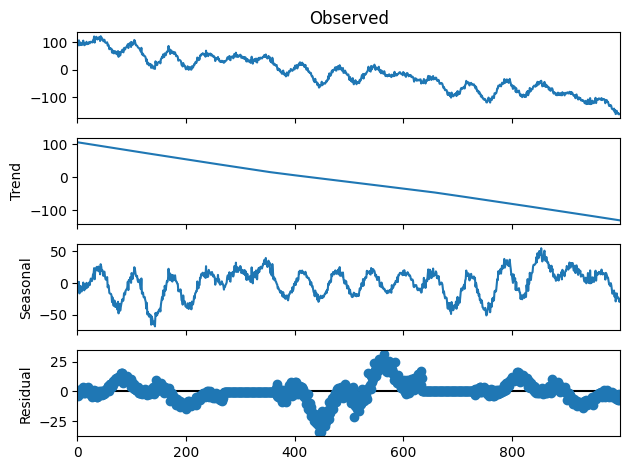

In [9]:
from statsmodels.tsa.seasonal import STL  # я выбрал именно STL вместо seasonal_decompose, чтобы по краям не было пустых значений


stl_result = STL(values, period=365).fit()
stl_result.plot()
plt.show()

#### Цикличность

Т.к. выше мы нашли уже тренд и сезонность, нужно теперь рассмотреть оставшиеся параметры в Residual - это цикличность и шум

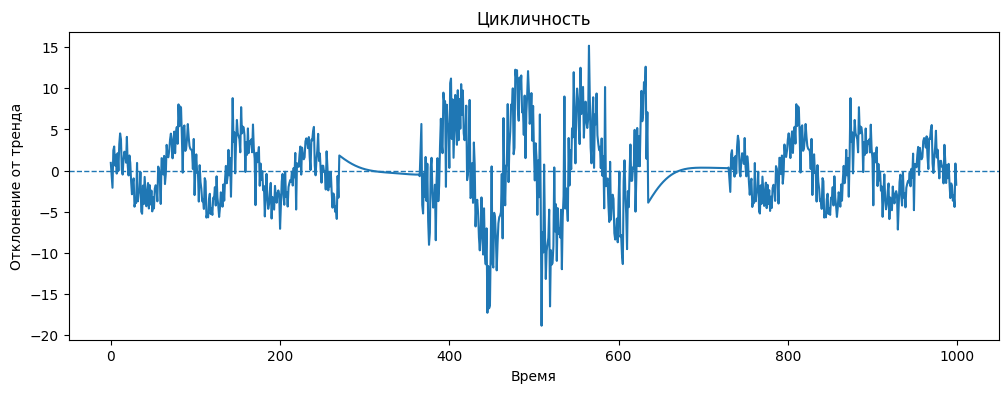

In [10]:
from statsmodels.tsa.filters.hp_filter import hpfilter


cycle, noise = hpfilter(stl_result.resid, lamb=100000)  # лямбда берётся такая большая, чтобы сглаживание было больше

plt.figure(figsize=(12, 4))
plt.plot(cycle)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Цикличность")
plt.xlabel("Время")
plt.ylabel("Отклонение от тренда")
plt.show()

### Задание 5. Автокорреляционные функции

Для автокорреляционных функций стоит использовать стационарный ряд. Его мы уже получили ранее - это остаток после удаления тренда и сезонности

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

stationary = stl_result.resid

#### ACF - Автокорреляционная функция

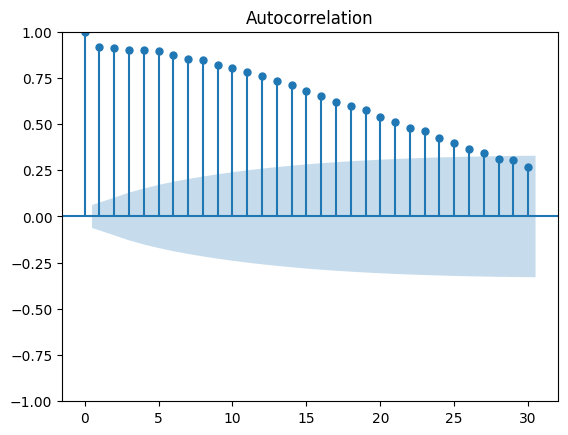

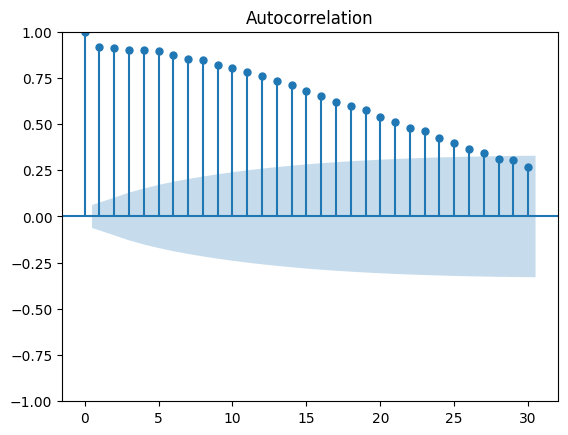

In [12]:
plot_acf(stationary)

### PACF - Частичная автокорреляционная функция

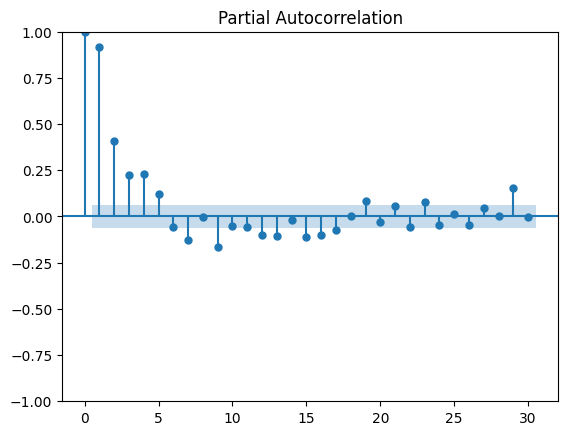

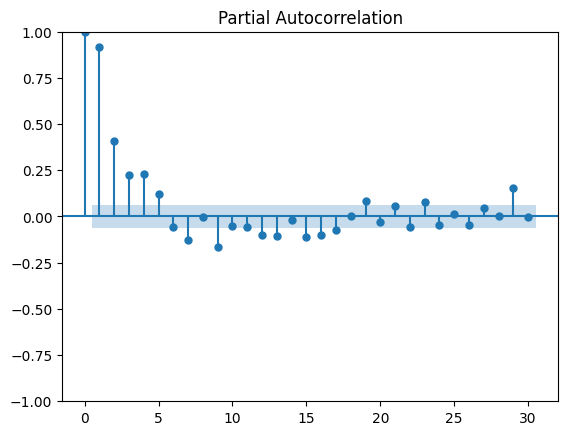

In [13]:
plot_pacf(stationary)

### Задание 6. Моделирование

#### Обоснование

Наш исходный ряд был нестационарным, в нём присутствовали тренд и сезонность. Для него нужно было бы применить модель SARIMA, чтобы сделать предсказание. Однако в ходе работы мы сделали ряд стационарным, а значит теперь для него можно применить модель ARMA. У неё самая простая реализация и нам не предётся искать какие-то параметры, кроме p и q, потому выбор пал именно на неё

#### Подбор параметров модели

Выше приведены графики ACF и PACF.

На первом графике видно, что ACF медленно снижается, и резких обрывов не происходит. Исходя из этого, порядок авторегресии p берём за 0

На втором графике видно, что сразу после 1 происходит резкий обрыв. Очевидно, порядок скользящей средней q = 1

Как уже было сказано выше, ряд был приведён к стационарному, значит параметр d = 0

#### Построение модели

In [14]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = 0, 0, 1

model = ARIMA(stationary, order=(p, d, q))
model_result = model.fit()

#### Предсказание

In [15]:
resid_forecast = model_result.get_forecast(steps=days_forecast)

Получившееся значение и будет предсказанием на остаток. Однако, если прямо сейчас добавить результат к исходному графику, то получится неверный ответ, т.к. в исходном графике были и сезонность и тренд.

Чтобы получить верное предсказание, нужно добавить сезонность и тренд

##### Сезонность

In [16]:
season_days = 66  # определяется из графика сезонности

seasonal_forecast = stl_result.seasonal[-season_days:][:days_forecast]

seasonal_last = stl_result.seasonal[-season_days:]    
seasonal_forecast = np.tile(seasonal_last, days_forecast // season_days + 1)[:days_forecast]  # если прогноз делается на большее кол-во дней, чем сезон

##### Тренд

Его экстраполируем через линейную регрессию

In [17]:
from sklearn.linear_model import LinearRegression

X = np.arange(days).reshape(-1, 1)

model = LinearRegression().fit(X, stl_result.trend)

X_future = np.arange(days, days+days_forecast).reshape(-1, 1)
trend_forecast = model.predict(X_future)

Финальное предсказание будет суммой всего вышеперечисленного

In [18]:
forecast = trend_forecast + seasonal_forecast + resid_forecast.predicted_mean

### Задание 7. Анализ метрик

In [19]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [20]:
mean_absolute_error(values_true, forecast)

17.406252487473516

In [21]:
root_mean_squared_error(values_true, forecast)

21.334504180019774

Значения метрик MAE и RMSE не очень большие, а значит модель имеет приемлемую точность

### Задание 8. Отрисовка конечного результата

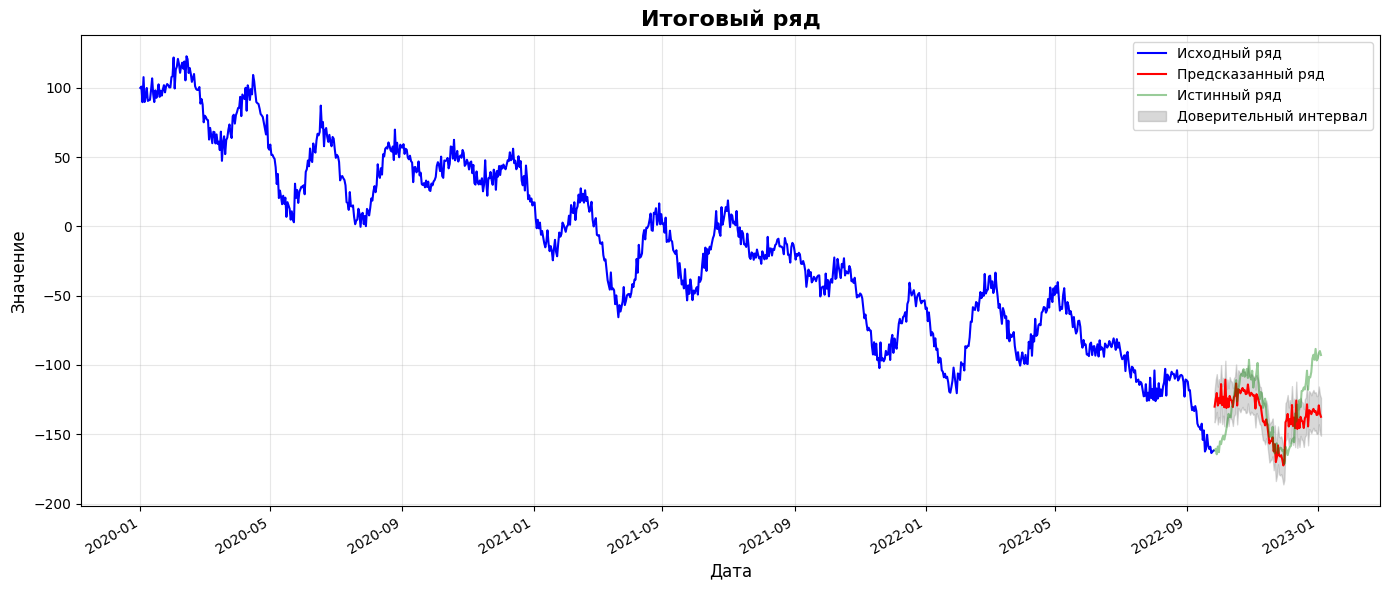

In [22]:
# Доверительный интервал
conf_int = resid_forecast.conf_int()
min_forecast, max_forecast = trend_forecast + seasonal_forecast + conf_int[:,0], trend_forecast + seasonal_forecast + conf_int[:,1]

# Преобразуем строки дат в объекты datetime для matplotlib
dates_format = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in dates]
dates_forecast_format = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in dates_forecast]

plt.figure(figsize=(14, 6))

# Строим график временного ряда
plt.plot(dates_format, values, label='Исходный ряд', color='blue', linewidth=1.5)
plt.plot(dates_forecast_format, forecast, label='Предсказанный ряд', color='red', linewidth=1.5)
plt.plot(dates_forecast_format, values_true, label='Истинный ряд', color='green', linewidth=1.5, alpha=0.4)
plt.fill_between(dates_forecast_format, min_forecast, max_forecast, color='grey', alpha=0.3, label="Доверительный интервал")
plt.title('Итоговый ряд', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Автоматически форматируем ось X для дат
plt.gcf().autofmt_xdate()

plt.tight_layout()

plt.show()